In [52]:
import torch
import time
import librosa
import pathlib
import numpy as np
import pandas as pd
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

from torch import nn, optim
from dataclasses import dataclass
from tqdm import tqdm
from train_net import train
from scipy.io.wavfile import write
from torch.utils.data import TensorDataset, DataLoader

In [53]:
def preprocess_audio(
    filename,
    spec_params,
):

    audio, sample_rate = librosa.load(filename, sr=spec_params.sample_rate)
    audio, _ = librosa.effects.trim(audio, top_db=20)

    if len(audio) < 0.1 * sample_rate:
        return None

    if len(audio) < spec_params.target_length:
        audio = np.pad(audio, (0, spec_params.target_length - len(audio)), "constant")
    else:
        audio = audio[: spec_params.target_length]

    S = librosa.feature.melspectrogram(
        y=audio,
        sr=sample_rate,
        n_mels=spec_params.n_mels,
        n_fft=spec_params.n_fft,
        win_length=spec_params.window_length,
    )

    S_dB = 20 * np.log10(S + 1e-6)
    S_dB = (S_dB - np.max(S_dB)) / (np.max(S_dB) - np.min(S_dB))

    return S_dB

In [54]:
def create_dataset(audios_folder, data_labels, specgram_params):
    audio_files = pathlib.Path(audios_folder).rglob("*.wav")
    df = pd.DataFrame({"filename": list(audio_files)})
    print("Number of images in dataset: ", len(df))

    df["label"] = df.filename.apply(lambda x: str(x).split("/")[-2])
    df["y"] = df.label.map(data_labels)

    specgrams = []
    labels = []

    for audio in tqdm(range(len(df))):
        row = df.iloc[audio]
        features_v = preprocess_audio(row["filename"], specgram_params)

        if features_v is None:
            continue

        labels.append(row["y"])
        specgrams.append(features_v[np.newaxis, :, :])

    X_tensor = torch.tensor(np.array(specgrams), dtype=torch.float32)
    Y_tensor = torch.tensor(np.array(labels), dtype=torch.long)

    dataset = TensorDataset(X_tensor, Y_tensor)

    return dataset

In [55]:
@dataclass
class SpectrogramParams:
    n_mels: int
    sample_rate: int
    frame_duration: float
    window_length: int
    n_fft: int
    target_length: int


target_duration = 1.1  # target duration in seconds
frame_duration = 0.03  # frame duration in seconds
sample_rate = 16000
window_length = round(frame_duration * sample_rate)

spec_params = SpectrogramParams(
    n_mels=32,
    sample_rate=16000,
    frame_duration=frame_duration,
    window_length=window_length,
    n_fft=2 ** (round(window_length) - 1).bit_length(),
    target_length=round(target_duration * sample_rate),
)

data_labels = {
    "cero": 0,
    "uno": 1,
    "dos": 2,
    "tres": 3,
    "cuatro": 4,
    "cinco": 5,
    "seis": 6,
    "siete": 7,
    "ocho": 8,
    "nueve": 9,
}

training_dataset = create_dataset("data/train/", data_labels, spec_params)
validation_dataset = create_dataset("data/test", data_labels, spec_params)

Number of images in dataset:  12812


100%|██████████| 12812/12812 [00:34<00:00, 375.80it/s]


Number of images in dataset:  3082


100%|██████████| 3082/3082 [00:08<00:00, 381.94it/s]


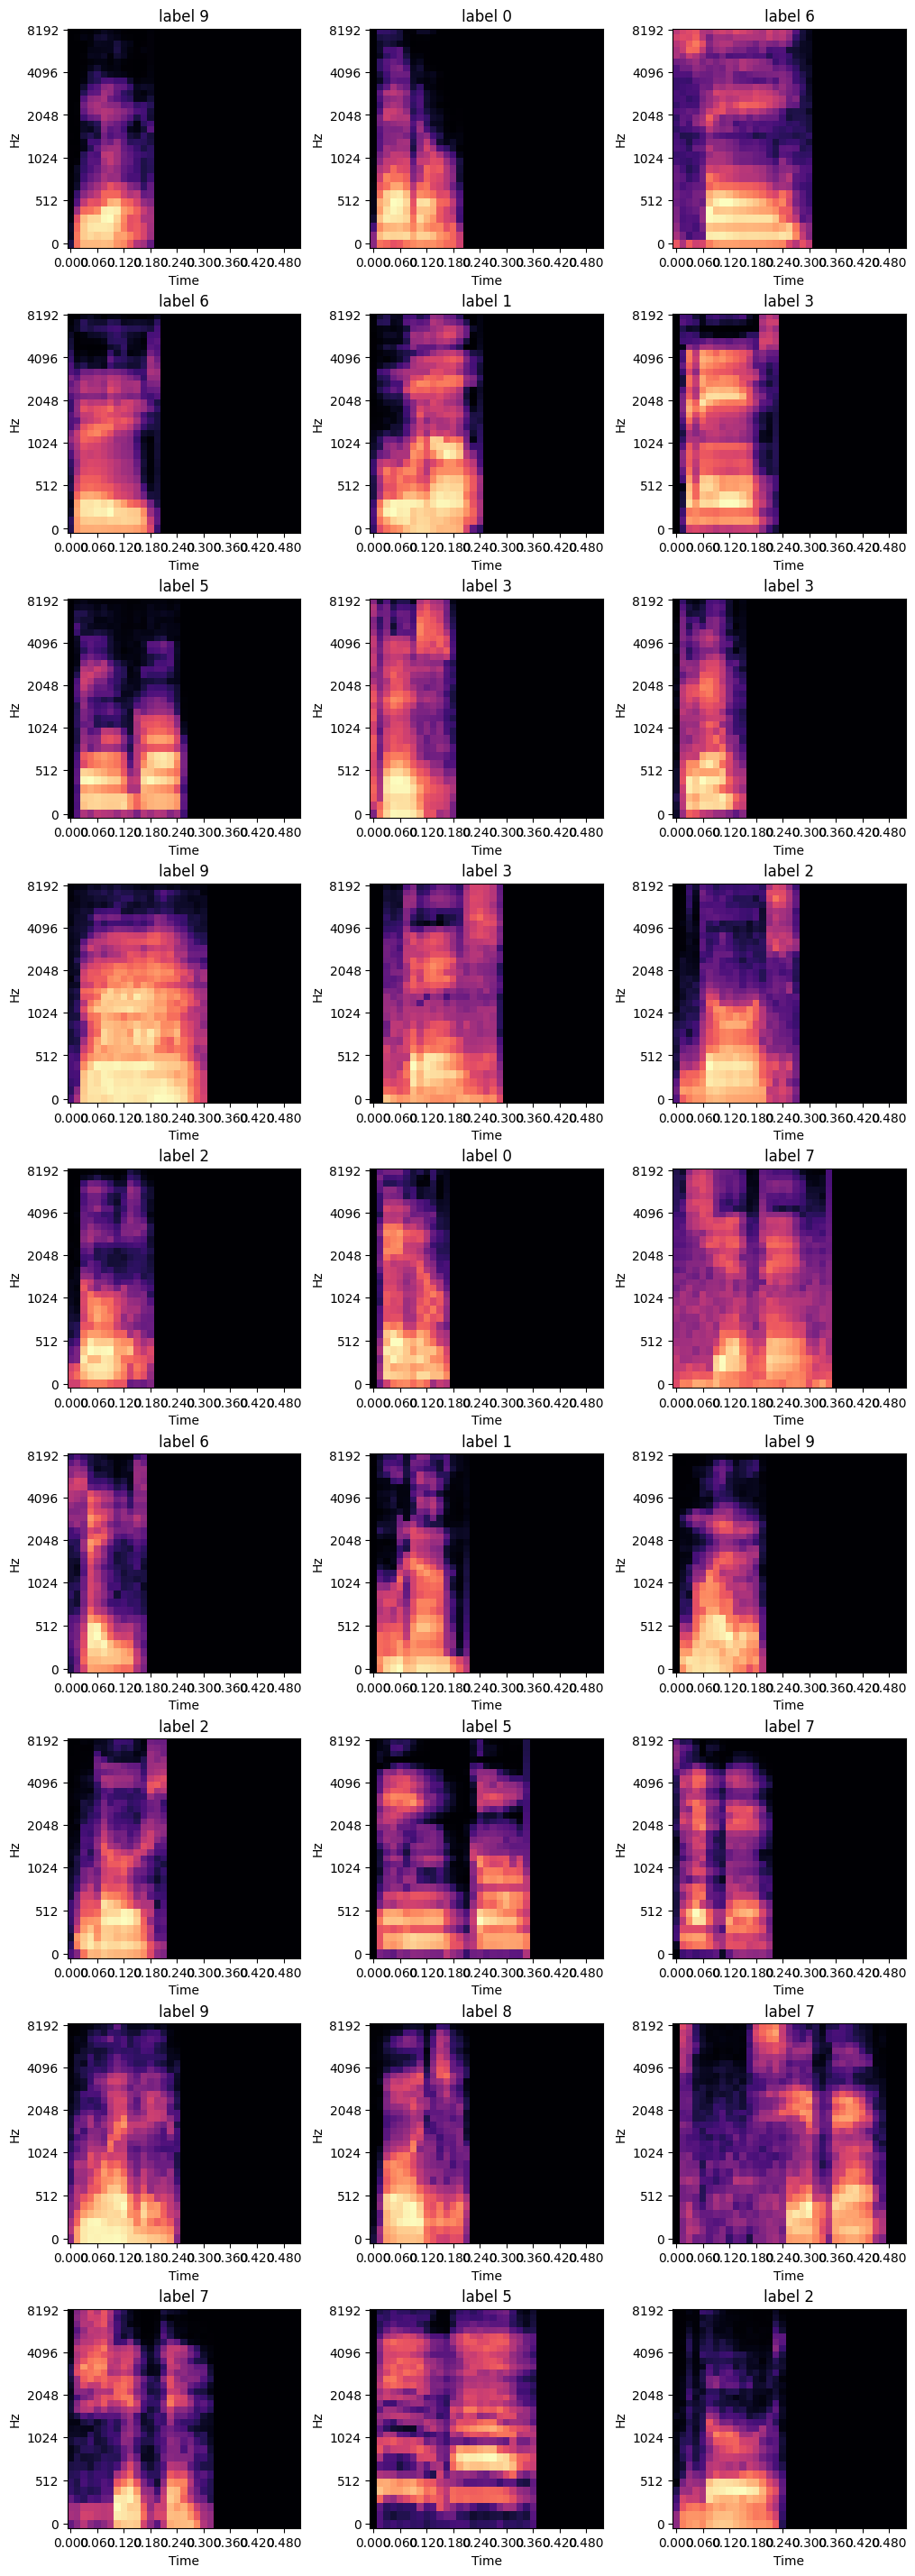

In [56]:
def show_samples(dataset, nrows=9, ncols=3):
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    axl = ax.flatten()

    num_samples = len(training_dataset)
    for k in range(len(axl)):
        sample_idx = np.random.randint(0, num_samples)
        spec, label = dataset[sample_idx]
        librosa.display.specshow(
            spec[0].numpy(),
            sr=16000,
            hop_length=240,
            x_axis="time",
            y_axis="mel",
            ax=axl[k],
        )
        # axl[k].imshow(spec[0])
        axl[k].set_title(f"label {label}")
    plt.subplots_adjust(hspace=0.3, wspace=0.3)


show_samples(training_dataset)

In [57]:
class conv_layer(nn.Sequential):
    def __init__(self, input_feat, out_feat, max_pool=True):
        layers = []
        layers.append(nn.Conv2d(input_feat, out_feat, 3, padding=1))
        layers.append(nn.BatchNorm2d(out_feat))
        layers.append(nn.ReLU())

        if max_pool:
            layers.append(nn.MaxPool2d(3, 2, padding=1))
        super().__init__(*layers)

In [58]:
# Modulo final antes de la salida, no tiene parametros por tanto no hace falta init
class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x, start_dim=1)

In [59]:
class MyNet(nn.Sequential):
    def __init__(self, dropoutProb=0.2, num_classes=10):
        input_channels = 1
        numF = 16

        layers = []
        layers.append(conv_layer(input_channels, numF))
        layers.append(conv_layer(numF, numF * 2))
        layers.append(conv_layer(2 * numF, 4 * numF))
        layers.append(conv_layer(4 * numF, 4 * numF, max_pool=False))
        layers.append(conv_layer(4 * numF, 4 * numF, max_pool=False))
        layers.append(nn.AdaptiveMaxPool2d((4, 1)))
        layers.append(nn.Dropout2d(dropoutProb))
        layers.append(Flatten())
        layers.append(nn.Linear(64 * 4, num_classes))

        super().__init__(*layers)

In [60]:
device = "cpu"

# Define learning rate
learning_rate = 0.001
batch_size = 512

# Define network
red = MyNet()

# Create Adam optimizer
# optimizer = optim.SGD(red.parameters(), lr=learning_rate, momentum =0.9)
optimizer = optim.Adam(red.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 30
train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

start_time = time.time()
torch.set_num_threads(4)
train_losses, val_losses, train_acc, val_acc = train(
    red, loss_fn, train_dataloader, val_dataloader, optimizer, num_epochs, device=device
)

torch.save(red.state_dict(), "model.pth")
print(f"Train finished in {time.time()- start_time} seconds")

fig, axes = plt.subplots(2, 1)
axes[0].plot(train_losses, label="train loss")
axes[0].plot(val_losses, label="val_loss")
axes[0].legend()
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("Loss")

axes[1].plot(train_acc, label="train_acc")
axes[1].plot(val_acc, label="val acc")
axes[1].legend()
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("Accuracy")

Training Progress: 100%|██████████| 30/30 [03:12<00:00,  6.42s/it, Train Loss=0.00151, Val Loss=0.0592, Train Acc=1, Val Acc=0.977, Best Val Acc=0.977]    


AttributeError: module 'torch' has no attribute 'savek'

In [ ]:
# duration = 3
# freq = 16000
# record = sd.rec(int(duration * freq), samplerate=freq, channels=1)
# sd.wait()
# write("file.wav", 16000, record)

In [ ]:
# audio_data, fs = librosa.load("file.wav", sr=None)
# t = np.arange(len(audio_data)) / fs
# plt.plot(t, audio_data)
# # = plt.xlabel("time")

In [ ]:
# S = preprocess_audio("file.wav")
# librosa.display.specshow(S, sr=16000, hop_length=240, x_axis="time", y_axis="mel")

In [ ]:
# red.eval()

# x = torch.from_numpy(S.astype(np.float32))
# x = x.unsqueeze(0).unsqueeze(0)  # añadimos dimensiones para poder hacer la inferencia
# x = x.to(device)
# y = red(x)
# print("Has dicho: ", torch.argmax(y).item())  # clasificamos con el máximo